In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
# 모델 다운로드
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


## 인물 모드 직접 해보기

In [99]:
#이미지 불러오기
img_path = os.getenv('HOME')+'/aiffel/exploration/exploration_08/images'
img_orig = cv2.imread(os.path.join(img_path, "me.jpg"))
img_orig2 = cv2.imread(os.path.join(img_path, "me2.jpg"))
img_cat = cv2.imread(os.path.join(img_path, "cat.jpg"))
img_chroma = cv2.imread(os.path.join(img_path, "beach.jpg"))
print (img_orig.shape)
print (img_orig2.shape)
print (img_cat.shape)
print (img_chroma.shape)

(1280, 960, 3)
(960, 1280, 3)
(400, 600, 3)
(2000, 2667, 3)


In [61]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1280, 960, 3) (513, 384, 3) 15


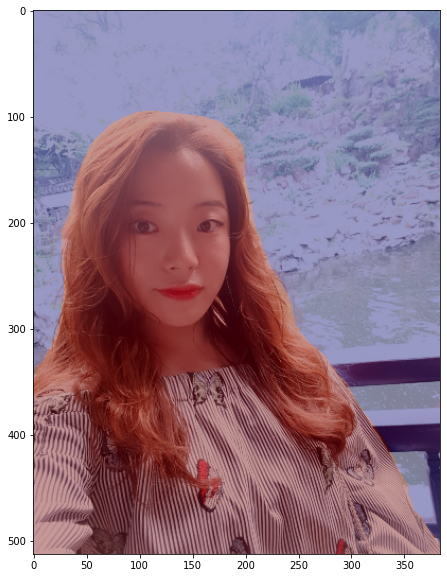

In [62]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8) # image mask
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

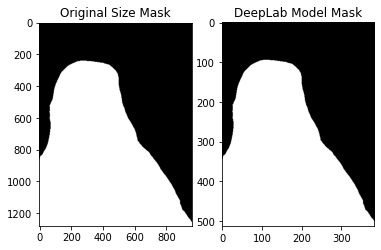

In [63]:
# 만들어진 세크멘테이션으로 마스크 생성
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

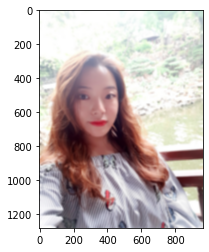

In [64]:
#이미지 블러처리
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

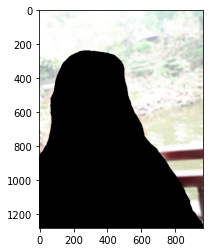

In [66]:
# 세그멘테이션 영역만 뺴서 배경 얻기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

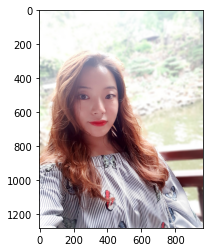

In [67]:
# 인물 사진!
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 배경합성하기

In [68]:
img_chroma = cv2.imread(os.path.join(img_path, "beach.jpg"))
print(img_chroma.shape)

(2000, 2667, 3)


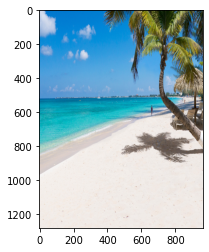

In [69]:
#배경 resize
chroma_show = img_chroma.copy()
background_resized = cv2.resize(chroma_show, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
plt.imshow(cv2.cvtColor(background_resized, cv2.COLOR_BGR2RGB))
plt.show()

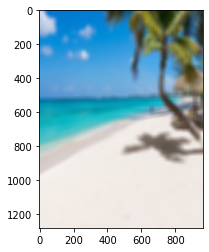

In [70]:
#배경을 블러처리
background_blur = cv2.blur(background_resized, (30,30))
plt.imshow(cv2.cvtColor(background_blur, cv2.COLOR_BGR2RGB))
plt.show()

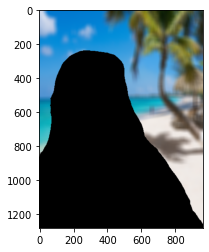

In [71]:
#마슼크 영역 제거
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(background_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

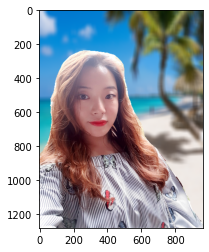

In [72]:
#인물과 배경 합성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 고양이 사진

In [83]:
img_cat = cv2.imread(os.path.join(img_path, "cat.jpg"))
print (img_cat.shape)

(400, 600, 3)


In [84]:
cat_resized, seg_map = MODEL.run(img_cat)
print (img_orig.shape, img_resized.shape, seg_map.max())

(1280, 960, 3) (513, 384, 3) 8


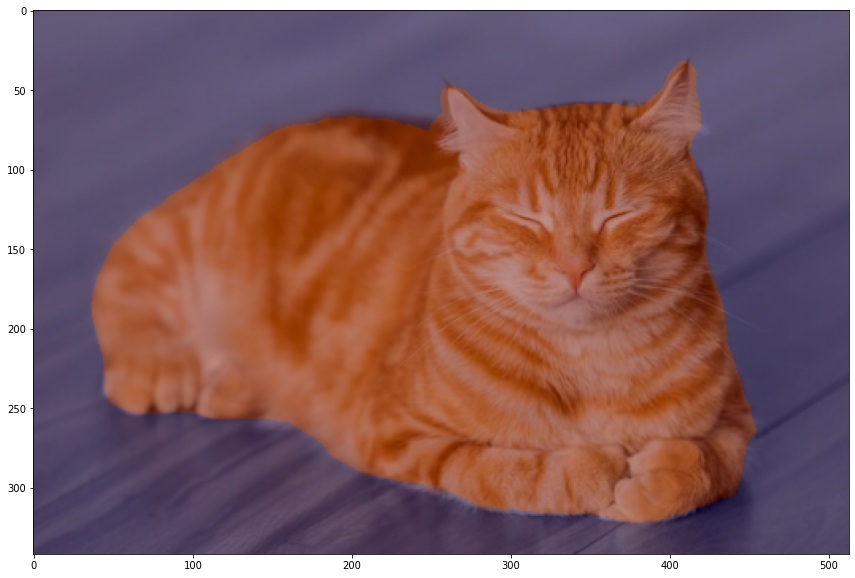

In [85]:
img_show = cat_resized.copy()
seg_map = np.where(seg_map == 8, 8, 0) # 예측 중 고양이만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8) # image mask
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

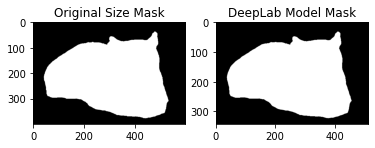

In [86]:
# 만들어진 세크멘테이션으로 마스크 생성
img_mask_up = cv2.resize(img_mask, img_cat.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

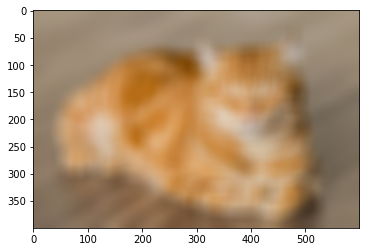

In [88]:
#배경을 블러처리
cat_blur = cv2.blur(img_cat, (30,30))
plt.imshow(cv2.cvtColor(cat_blur, cv2.COLOR_BGR2RGB))
plt.show()

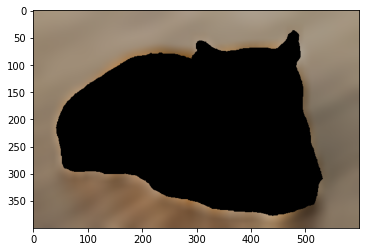

In [89]:
#마슼크 영역 제거
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(cat_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

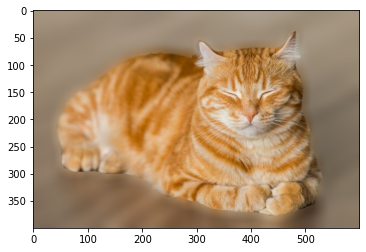

In [90]:
cat_concat = np.where(img_mask_color==255, img_cat, img_bg_blur)
plt.imshow(cv2.cvtColor(cat_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 다른 사진으로 인물 사진 모드

In [109]:
img_resized, seg_map = MODEL.run(img_orig2)
print (img_orig2.shape, img_resized.shape, seg_map.max())

(960, 1280, 3) (384, 513, 3) 15


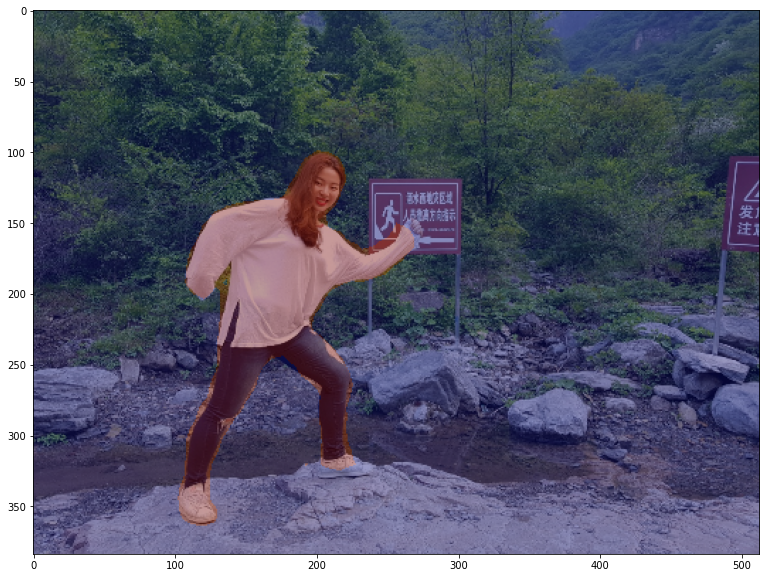

In [110]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8) # image mask
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

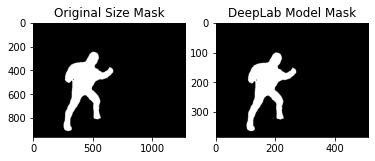

In [111]:
# 만들어진 세크멘테이션으로 마스크 생성
img_mask_up = cv2.resize(img_mask, img_orig2.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

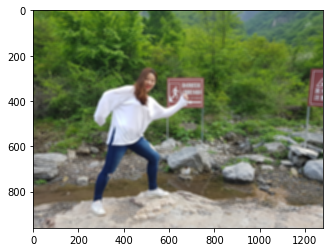

In [118]:
#이미지 블러처리
img_orig_blur2 = cv2.blur(img_orig2, (30,30))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

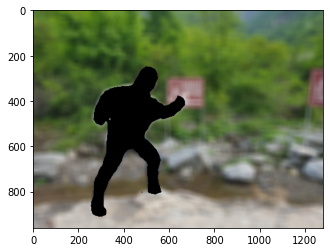

In [119]:
# 세그멘테이션 영역만 뺴서 배경 얻기
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur2, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

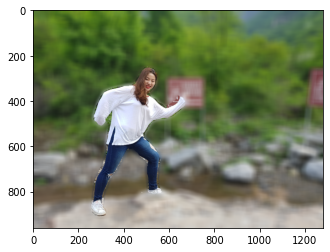

In [120]:
# 인물 사진!
img_concat = np.where(img_mask_color==255, img_orig2, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 문제점

![](https://8888wsbqeej37i0a4rxirlhmfum2i.c2.prod.connect.ainize.ai/view/aiffel/exploration/exploration_08/images/wrong.PNG)

![](https://8888-wsbqeej37i0a4rxirlhmfum2i.c2.prod.connect.ainize.ai/view/aiffel/exploration/exploration_08/images/wrong.PNG)

![](https://8888-wsbqeej37i0a4rxirlhmfum2i.c2.prod.connect.ainize.ai/view/aiffel/exploration/exploration_08/images/wrong.PNG)

In [124]:
from IPython.display import Image

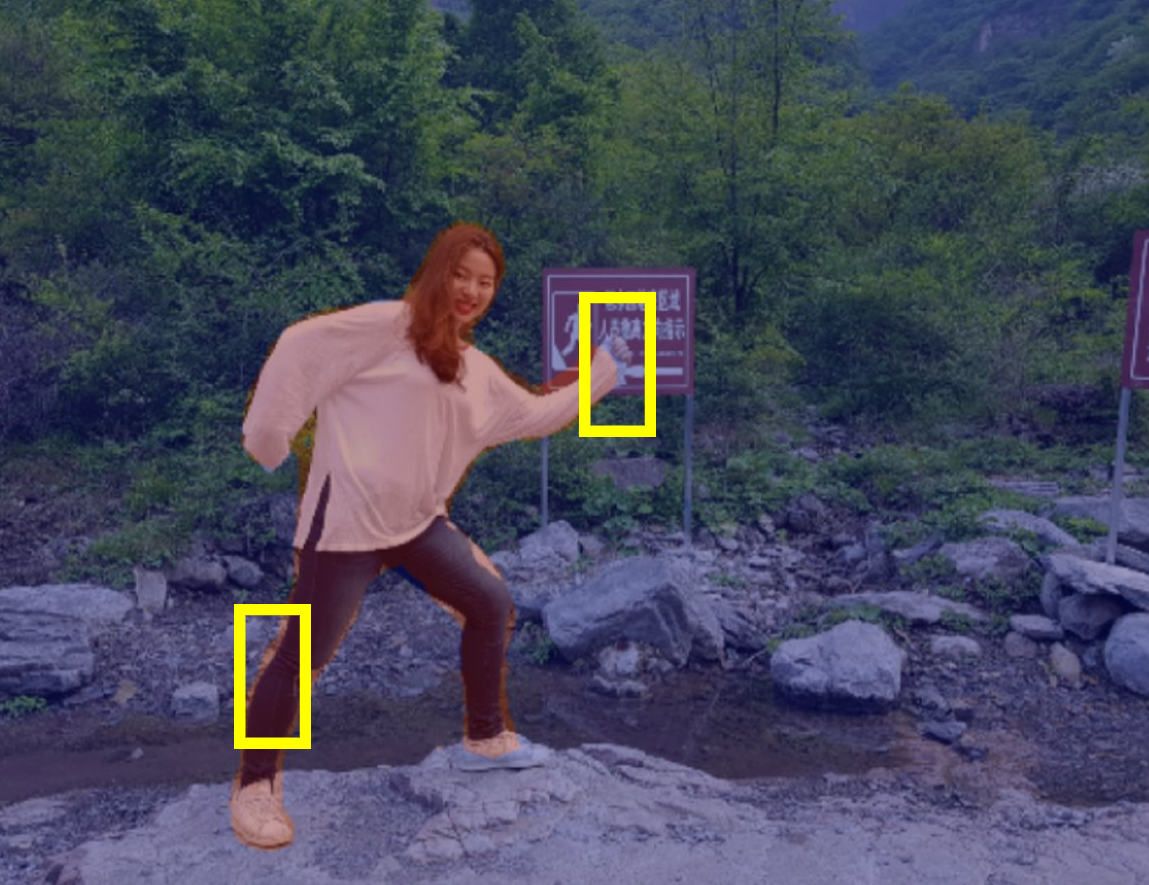

In [125]:
Image('/aiffel/aiffel/exploration/exploration_08/images/wrong.PNG')

- 세그멘테이션에 배경의 일부분이 포함되어 있음. 

- 또한, 손같은 경우에는 세그멘테이션에서 제외된 모습을 볼 수 있음. 

## 솔루션 제시

- 현재 사진에서 배경의 일부분이 포함되어 있는 것은, 피사체와 뒷 배경의 깊이의 차이를 제대로 인식하지 못한 것이라고 생각한다.3d 깊이 카메라 기술을 사용해 이를 해결해볼 수 있다. 위의 기술은 기존 픽셀의 rgb, 채도, contrast뿐만 아니라픽셀의 깊이정보까지 습득할 수 있는 기술이다. 여러개의 카메라를 사용해 그들의 시점 불일치를 이용하는 스테레오 방식, 수신된 광신호의 시간 정보를 이용한 TOF방식, 광학 3D스캐닝 방법인 Structured Pattern 방식등이 있다. 

- 인물의 outline을 제대로 인식하지 못하는 문제에 대해 위의 방법과 더불어 rgb색채의 클러스터링을 이용해보아도 정확도가 올라갈 수 있을 것이다. 




## 회고록

- 사실 과제를 구현하는 것 자체는 그렇게 어렵진 않았다. 어느정도 코드에 대해 이해를 하고 그것을 적용시키면 되었다. 

- 하지만 정말 문제는 이론에 대한 이해이다. cv에 대한 이해도가 낮으니 위의 프로젝트의 설명에도 이해가 낮아 이론 부문을 읽는 것은 굉장히 힘들었다. 

- 추후에는 조금 더 깊게 공부해서 나와있는 정보 뿐만 아니라 다양한 소스를 가지고 공부해야 겠다. 